<a href="https://colab.research.google.com/github/Mhanyn/Brain-Tumor-Detector/blob/main/Brain_Tumor_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, applications, callbacks, regularizers
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("TensorFlow version:", tf.__version__)


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Suppress TensorFlow logger warnings
tf.get_logger().setLevel('ERROR')

TensorFlow version: 2.10.1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# # Define constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 25  # Reduced for computational efficiency

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rm1000/brain-tumor-mri-scans")

print("Path to dataset files:", path)
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    seed=123,
    shuffle=True,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Path to dataset files: C:\Users\Excalibur\.cache\kagglehub\datasets\rm1000\brain-tumor-mri-scans\versions\1
Found 7023 files belonging to 4 classes.


In [ ]:
# Load the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Further split validation set to create a test set
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)

class_names = train_ds.class_names
print("Class names:", class_names)

Found 7023 files belonging to 4 classes.
Using 5619 files for training.
Found 7023 files belonging to 4 classes.
Using 1404 files for validation.
Class names: ['glioma', 'healthy', 'meningioma', 'pituitary']


# Class Distribution Analysis

In [ ]:
class_names=dataset.class_names
class_names

['glioma', 'healthy', 'meningioma', 'pituitary']

In [ ]:
# Calculate the Class Counts
class_counts = {}
for images, labels in dataset.as_numpy_iterator():
    for label in labels:
        class_label = class_names[label]
        if class_label in class_counts:
            class_counts[class_label] += 1
        else:
            class_counts[class_label] = 1

# Output the counts
for class_name in class_names:
    count = class_counts.get(class_name, 0)
    print(f"Class {class_name}: {count} images")

Class glioma: 1621 images
Class healthy: 2000 images
Class meningioma: 1645 images
Class pituitary: 1757 images


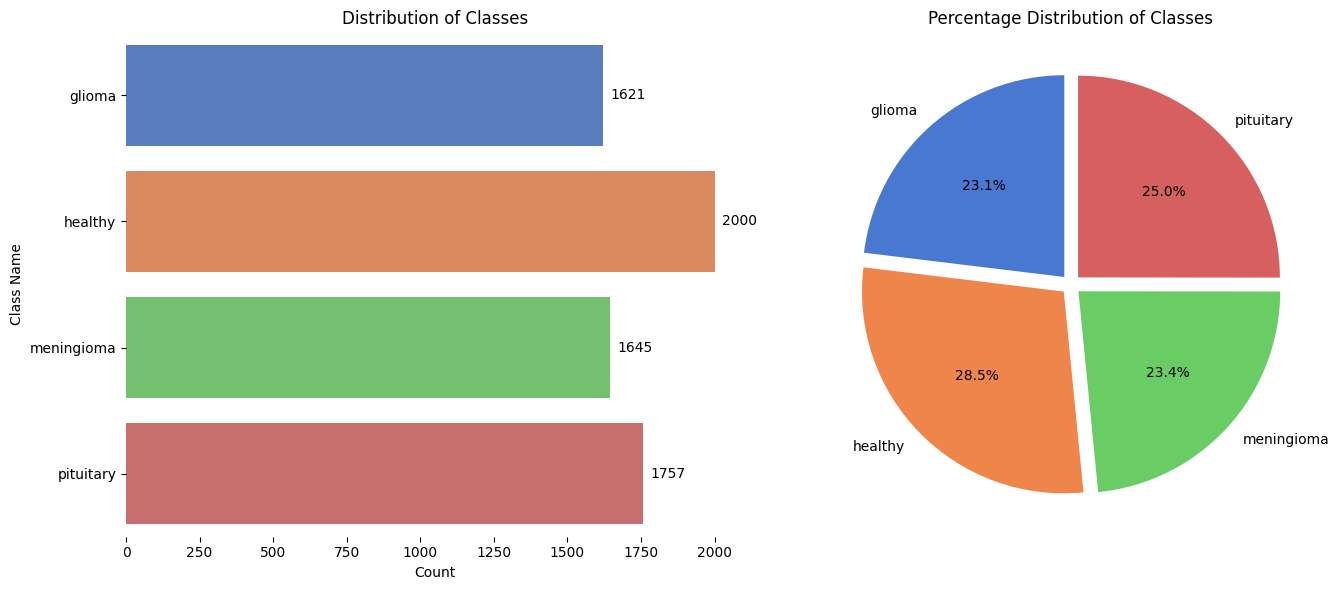

In [ ]:
# Collect the counts per class as a list
counts = [class_counts.get(class_name, 0) for class_name in class_names]

df = pd.DataFrame({
    'Class': class_names,
    'Count': counts
})

# Plotting
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.barplot(y='Class', x='Count', data=df, palette='muted')
plt.title('Distribution of Classes')
plt.xlabel('Count')
plt.ylabel('Class Name')
ax = plt.gca()
for p in ax.patches:
    width = p.get_width()
    ax.annotate(f'{int(width)}', (width, p.get_y() + p.get_height() / 2),
                ha='left', va='center', xytext=(5, 0), textcoords='offset points')
sns.despine(left=True, bottom=True)

plt.subplot(1, 2, 2)
df.set_index('Class')['Count'].plot.pie(autopct='%1.1f%%', colors=sns.color_palette('muted'),
                                        startangle=90, explode=[0.05]*len(class_names))
plt.title('Percentage Distribution of Classes')
plt.ylabel('')  # Remove the y-label for a cleaner look

plt.tight_layout()
plt.show()


## Pixel Intensity Statistics

In [ ]:
def get_pixel_stats(dataset, class_names):
    class_pixel_data = {name: [] for name in class_names}  # Dictionary to store pixel data for each class

    for images, labels in dataset.as_numpy_iterator():
        for image, label in zip(images, labels):
            class_label = class_names[label]
            class_pixel_data[class_label].append(image.flatten())  # Flatten and store pixel data directly

    # Calculate mean and std dev for each class
    pixel_stats = {}
    for class_name, pixels in class_pixel_data.items():
        pixels = np.concatenate(pixels)  # Combine all pixels into a single array
        mean = np.mean(pixels)
        std = np.std(pixels)
        pixel_stats[class_name] = (mean, std)

    return pixel_stats

pixel_stats = get_pixel_stats(dataset, class_names)
for class_name, stats in pixel_stats.items():
    print(f"Mean: {stats[0]:.2f}, Std Dev: {stats[1]:.2f} -> {class_name} ")

Mean: 32.65, Std Dev: 39.72 -> glioma 
Mean: 60.08, Std Dev: 64.65 -> healthy 
Mean: 44.80, Std Dev: 51.03 -> meningioma 
Mean: 48.54, Std Dev: 42.48 -> pituitary 


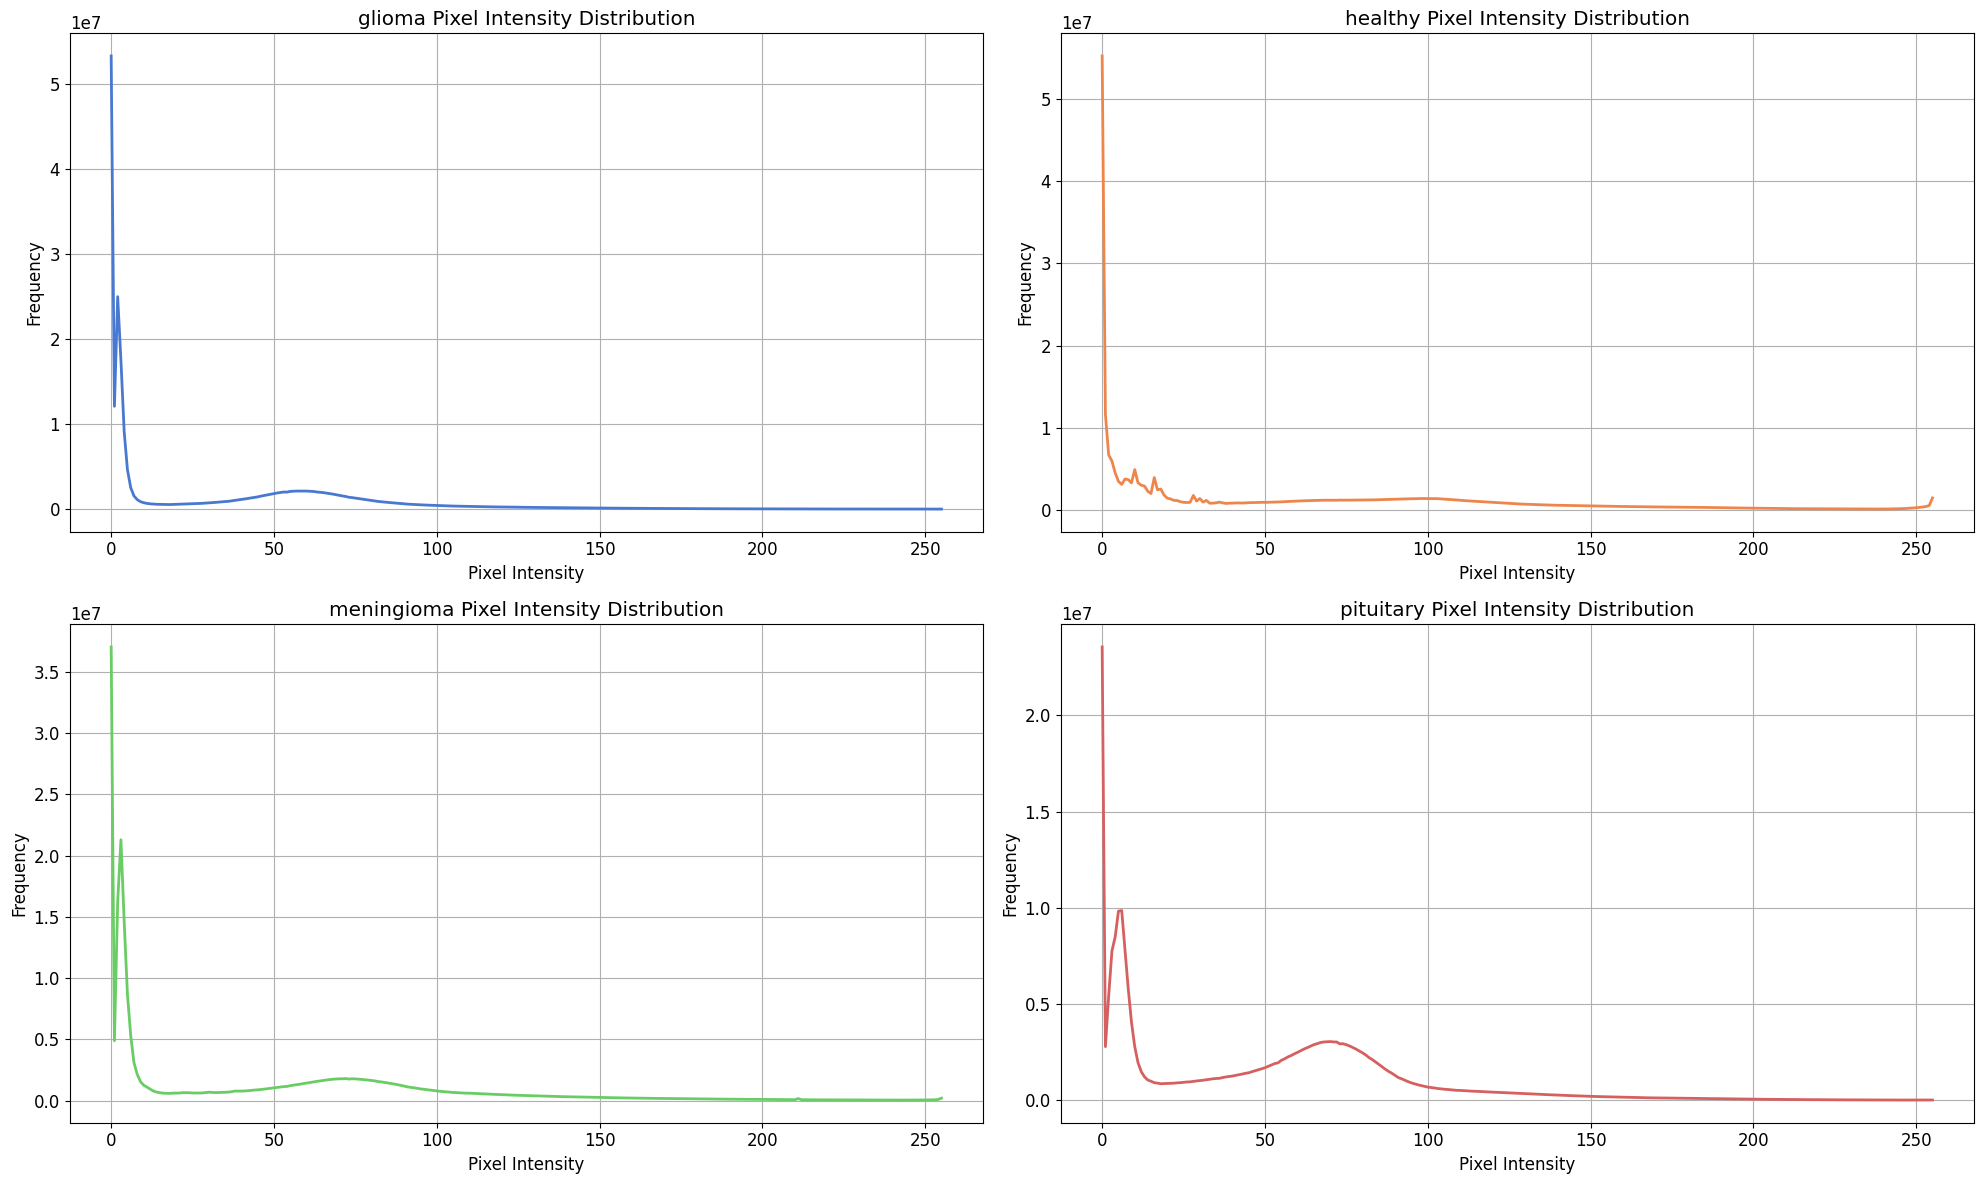

In [ ]:
def plot_pixel_histograms_efficient(dataset, class_names):
    plt.rcParams.update({'font.size': 12, 'font.family': 'sans-serif'})

    assert len(class_names) == 4, "This layout is configured for exactly 4 classes."

    colors = sns.color_palette('muted', n_colors=len(class_names))

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))
    axes = axes.flatten()

    hist_data = {name: np.zeros(256) for name in class_names}
    for images, labels in dataset.as_numpy_iterator():
        for image, label in zip(images, labels):
            class_label = class_names[label]
            pixels = image.flatten()
            counts, _ = np.histogram(pixels, bins=256, range=(0, 255))
            hist_data[class_label] += counts

    # Plot histograms using line plots
    for ax, (class_name, counts), color in zip(axes, hist_data.items(), colors):
        ax.plot(range(256), counts, color=color, linewidth=2)
        ax.set_title(f'{class_name} Pixel Intensity Distribution')
        ax.set_xlabel('Pixel Intensity')
        ax.set_ylabel('Frequency')
        ax.grid(True)

    plt.tight_layout()
    plt.show()

plot_pixel_histograms_efficient(dataset, class_names)

In [ ]:
# gets the total number of batches in the dataset
len(dataset)

220

In [ ]:
# This loop will print the shape of the images and labels in the first batch
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)  # Shape of the images in the batch (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
    print(label_batch.numpy())

(32, 224, 224, 3)
[3 3 3 3 2 2 1 2 1 0 1 1 3 0 3 0 1 0 0 2 1 3 1 3 3 2 2 3 0 2 3 1]


In [ ]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].shape)

(224, 224, 3)


### Insights from Dataset Exploration

1. **Dataset Properties**:
   - The dataset contains **7023 MRI images** of brain scans categorized into four classes: **glioma, healthy, meningioma, and pituitary**.
   - It is divided into **220 batches**, with each batch containing **32 images** (defined by the `BATCH_SIZE`).

2. **Class Distribution**:
   - The dataset is moderately balanced across the classes, as detailed:
     - **Glioma**: 1621 images
     - **Healthy**: 2000 images
     - **Meningioma**: 1645 images
     - **Pituitary**: 1757 images
   - The "Healthy" class has the highest representation, while "Glioma" has the lowest, necessitating techniques to address minor class imbalance.

3. **Image Dimensions**:
   - Each image has a resolution of **224x224 pixels** with **3 color channels (RGB)**. This is compatible with standard CNN architectures.
   - A single image's shape is confirmed as **(224, 224, 3)**.

4. **Label Encoding**:
   - Labels are encoded as integers corresponding to the class names:
     - **0** → Glioma
     - **1** → Healthy
     - **2** → Meningioma
     - **3** → Pituitary
   - Example labels from the first batch: `[3, 3, 3, 3, 2, 2, 1, 2, 1, 0, 1, 1, 3, 0, 3, 0, 1, 0, 0, 2, 1, 3, 1, 3, 3, 2, 2, 3, 0, 2, 3, 1]`.

5. **Pixel Intensity and Distribution**:
   - Mean and standard deviation of pixel intensities reveal distinct characteristics across classes:
     - **Glioma**: Mean = 32.65, Std Dev = 39.72
     - **Healthy**: Mean = 60.08, Std Dev = 64.65
     - **Meningioma**: Mean = 44.80, Std Dev = 51.03
     - **Pituitary**: Mean = 48.54, Std Dev = 42.48
   - Pixel intensity histograms highlight unique patterns for each class, which the model can exploit to differentiate the classes.

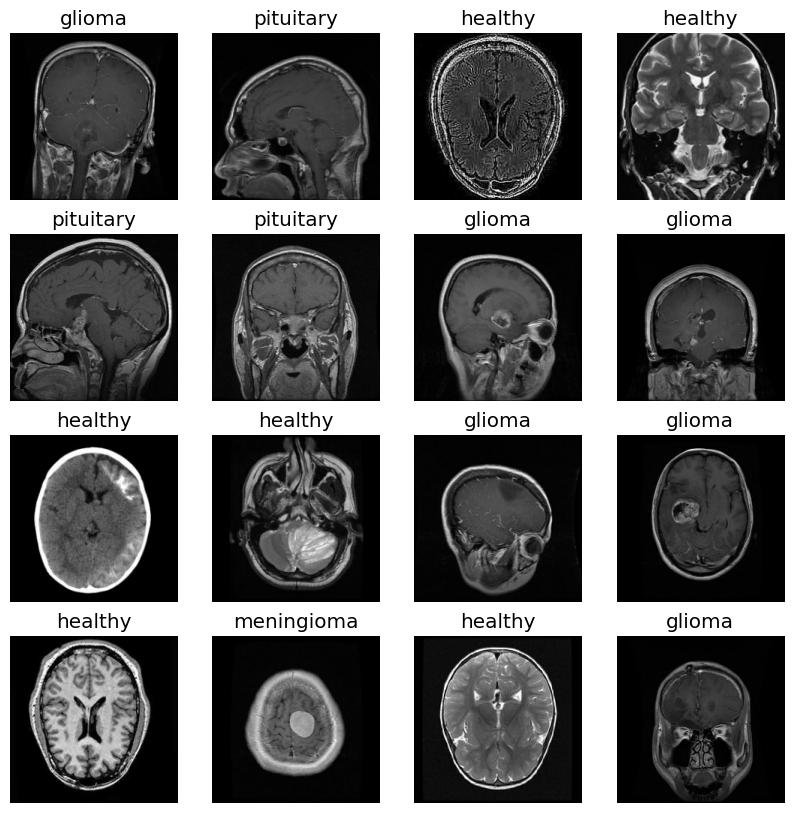

In [ ]:
# Visualize some images from the training dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis('off')
plt.show()

In [ ]:
# Data Augmentation Layer
data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1),
])

# Normalization Layer
normalization_layer = layers.Rescaling(1./255)

In [ ]:
# Prepare the datasets
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)
    ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

# Model Building

In [ ]:
def plot_model_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))
    plt.suptitle(title, fontsize=16)

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', color='blue')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='orange')
    plt.legend(loc='lower right')
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', color='blue')
    plt.plot(epochs_range, val_loss, label='Validation Loss', color='orange')
    plt.legend(loc='upper right')
    plt.title('Loss')
    plt.show()

# MODEL 1

In [ ]:
def build_model_1():
    model = keras.Sequential([
        layers.InputLayer(input_shape=IMG_SIZE + (3,)),
        data_augmentation,
        normalization_layer,
        layers.Conv2D(32, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(len(class_names), activation='softmax')
    ])
    return model

model_1 = build_model_1()
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                  

# MODEL 2

In [ ]:
def build_model_2():
    base_model = applications.DenseNet201(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
    base_model.trainable = True

    # Freeze all layers except the last few
    for layer in base_model.layers[:-50]:
        layer.trainable = False

    inputs = keras.Input(shape=IMG_SIZE + (3,))
    x = data_augmentation(inputs)
    x = base_model(x, training=True)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(class_names), activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    return model

model_2 = build_model_2()
model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_2 (Dense)             (None, 128)               245888    
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                               

# MODEL 3

In [ ]:
def build_model_3():
    base_model = applications.Xception(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
    base_model.trainable = True

    # Freeze all layers except the last few
    for layer in base_model.layers[:-50]:
        layer.trainable = False

    inputs = keras.Input(shape=IMG_SIZE + (3,))
    x = data_augmentation(inputs)
    x = base_model(x, training=True)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(class_names), activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    return model

model_3 = build_model_3()
model_3.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 128)               262272    
                                                                 
 batch_normalization_5 (Batc  (None, 128)              512       
 hNormalization)                                           

# Training models

In [ ]:
optimizer_list = [keras.optimizers.Adam(learning_rate=1e-4) for _ in range(3)]
loss = 'sparse_categorical_crossentropy'
metrics = ['accuracy']

In [ ]:
early_stop = callbacks.EarlyStopping(patience=5, restore_best_weights=True)
checkpoint_list = [callbacks.ModelCheckpoint(f'best_model_{i+1}.keras', save_best_only=True) for i in range(3)]

In [ ]:
model_1.compile(optimizer=optimizer_list[0], loss=loss, metrics=metrics)

history_1 = model_1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stop, checkpoint_list[0]]
)

Epoch 1/25
176/176 [==============================] - 92s 444ms/step - loss: 1.2944 - accuracy: 0.3712 - val_loss: 1.1306 - val_accuracy: 0.4857
Epoch 2/25
176/176 [==============================] - 83s 451ms/step - loss: 1.1255 - accuracy: 0.5214 - val_loss: 0.9820 - val_accuracy: 0.6300
Epoch 3/25
176/176 [==============================] - 81s 438ms/step - loss: 1.0442 - accuracy: 0.5739 - val_loss: 0.9219 - val_accuracy: 0.6243
Epoch 4/25
176/176 [==============================] - 80s 436ms/step - loss: 1.0231 - accuracy: 0.5857 - val_loss: 0.9070 - val_accuracy: 0.6343
Epoch 5/25
176/176 [==============================] - 80s 434ms/step - loss: 1.0003 - accuracy: 0.6005 - val_loss: 0.9035 - val_accuracy: 0.6400
Epoch 6/25
176/176 [==============================] - 80s 437ms/step - loss: 0.9850 - accuracy: 0.6030 - val_loss: 0.8843 - val_accuracy: 0.6486
Epoch 7/25
176/176 [==============================] - 80s 435ms/step - loss: 0.9869 - accuracy: 0.6017 - val_loss: 0.8837 - val_ac

In [ ]:
model_2.compile(optimizer=optimizer_list[1], loss=loss, metrics=metrics)

history_2 = model_2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stop, checkpoint_list[1]]
    )


Epoch 1/25
176/176 [==============================] - 128s 614ms/step - loss: 2.7068 - accuracy: 0.6839 - val_loss: 1.9284 - val_accuracy: 0.8414
Epoch 2/25
176/176 [==============================] - 105s 573ms/step - loss: 1.6528 - accuracy: 0.8612 - val_loss: 1.4207 - val_accuracy: 0.8857
Epoch 3/25
176/176 [==============================] - 105s 578ms/step - loss: 1.2858 - accuracy: 0.8870 - val_loss: 1.2106 - val_accuracy: 0.8743
Epoch 4/25
176/176 [==============================] - 106s 578ms/step - loss: 1.0813 - accuracy: 0.9174 - val_loss: 1.0520 - val_accuracy: 0.9043
Epoch 5/25
176/176 [==============================] - 105s 578ms/step - loss: 0.9643 - accuracy: 0.9244 - val_loss: 0.9321 - val_accuracy: 0.9157
Epoch 6/25
176/176 [==============================] - 105s 579ms/step - loss: 0.8507 - accuracy: 0.9375 - val_loss: 0.8516 - val_accuracy: 0.9286
Epoch 7/25
176/176 [==============================] - 105s 579ms/step - loss: 0.7718 - accuracy: 0.9422 - val_loss: 0.8027 -

In [ ]:
model_3.compile(optimizer=optimizer_list[2], loss=loss, metrics=metrics)

history_3 = model_3.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stop, checkpoint_list[2]]
)

Epoch 1/25
176/176 [==============================] - 122s 630ms/step - loss: 3.0251 - accuracy: 0.7407 - val_loss: 2.7442 - val_accuracy: 0.8657
Epoch 2/25
176/176 [==============================] - 112s 613ms/step - loss: 2.4421 - accuracy: 0.8795 - val_loss: 2.2612 - val_accuracy: 0.9143
Epoch 3/25
176/176 [==============================] - 111s 613ms/step - loss: 2.1010 - accuracy: 0.9172 - val_loss: 1.9595 - val_accuracy: 0.9186
Epoch 4/25
176/176 [==============================] - 111s 612ms/step - loss: 1.8329 - accuracy: 0.9283 - val_loss: 1.7280 - val_accuracy: 0.9286
Epoch 5/25
176/176 [==============================] - 111s 610ms/step - loss: 1.5646 - accuracy: 0.9457 - val_loss: 1.4624 - val_accuracy: 0.9443
Epoch 6/25
176/176 [==============================] - 112s 614ms/step - loss: 1.3309 - accuracy: 0.9525 - val_loss: 1.2729 - val_accuracy: 0.9386
Epoch 7/25
176/176 [==============================] - 111s 612ms/step - loss: 1.1254 - accuracy: 0.9578 - val_loss: 1.0754 -

# Evaluating the Models

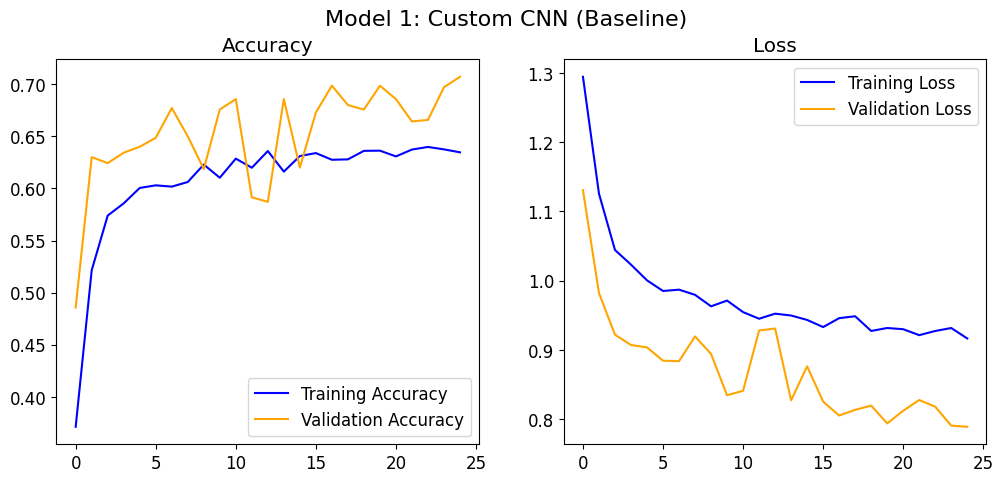

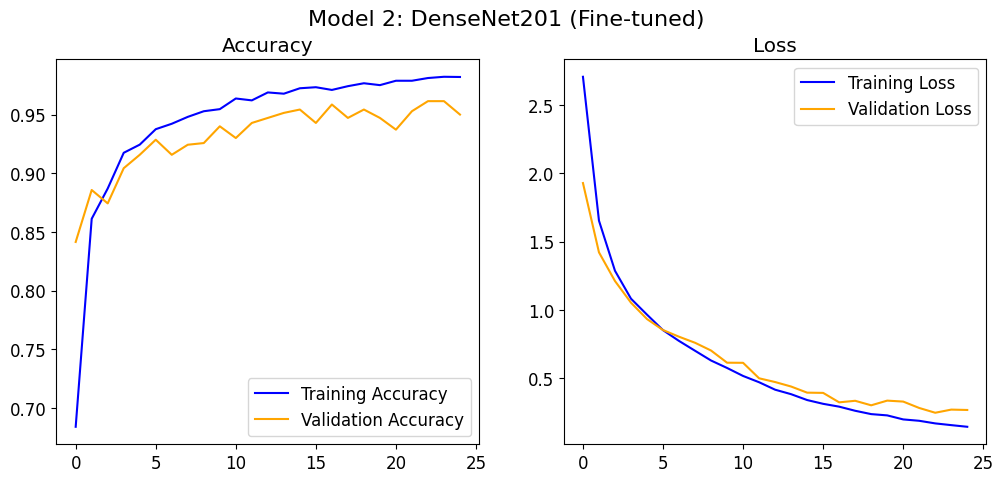

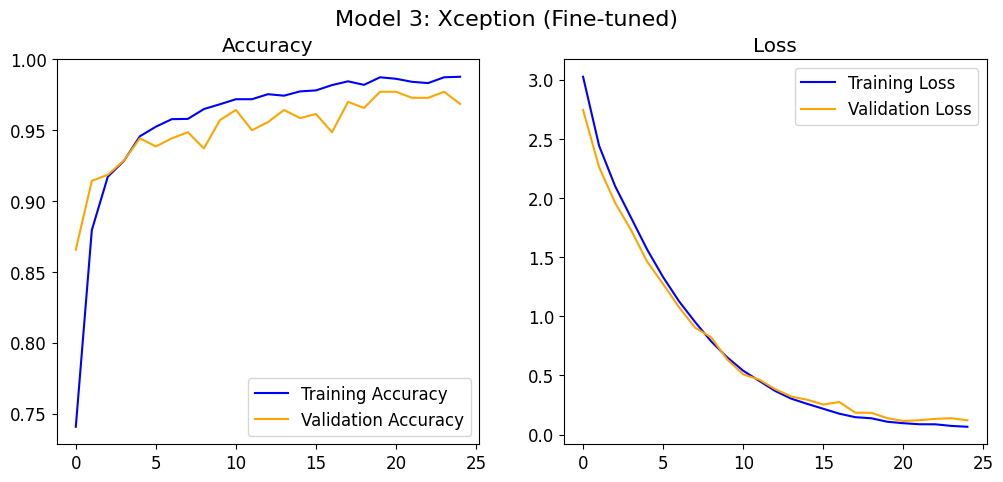

In [ ]:
plot_model_history(history_1, 'Model 1: Custom CNN (Baseline)')
plot_model_history(history_2, 'Model 2: DenseNet201 (Fine-tuned)')
plot_model_history(history_3, 'Model 3: Xception (Fine-tuned)')

In [ ]:
models_list = [model_1, model_2, model_3]
histories = [history_1, history_2, history_3]
model_names = ['Model 1', 'Model 2', 'Model 3']

test_loss_list = []
test_acc_list = []

for i, model in enumerate(models_list):
    print(f"Evaluating {model_names[i]}...")
    loss, acc = model.evaluate(test_ds)
    test_loss_list.append(loss)
    test_acc_list.append(acc)
    print(f'{model_names[i]} - Test Accuracy: {acc:.4f}, Test Loss: {loss:.4f}')

Evaluating Model 1...
22/22 [==============================] - 1s 28ms/step - loss: 0.8119 - accuracy: 0.6804
Model 1 - Test Accuracy: 0.6804, Test Loss: 0.8119
Evaluating Model 2...
22/22 [==============================] - 4s 169ms/step - loss: 0.2118 - accuracy: 0.9588
Model 2 - Test Accuracy: 0.9588, Test Loss: 0.2118
Evaluating Model 3...
22/22 [==============================] - 3s 142ms/step - loss: 0.0828 - accuracy: 0.9830
Model 3 - Test Accuracy: 0.9830, Test Loss: 0.0828


In [ ]:
def evaluate_model(model, name):
    y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)
    y_pred = np.argmax(model.predict(test_ds), axis=-1)

    # Classification Report
    print(f'Classification Report for {name}:\n')
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix for {name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# CONFUSION MATRICES

22/22 [==============================] - 1s 37ms/step
Classification Report for Model 1:

              precision    recall  f1-score   support

      glioma       0.21      0.23      0.22       155
     healthy       0.27      0.26      0.27       219
  meningioma       0.25      0.28      0.27       156
   pituitary       0.22      0.18      0.20       174

    accuracy                           0.24       704
   macro avg       0.24      0.24      0.24       704
weighted avg       0.24      0.24      0.24       704



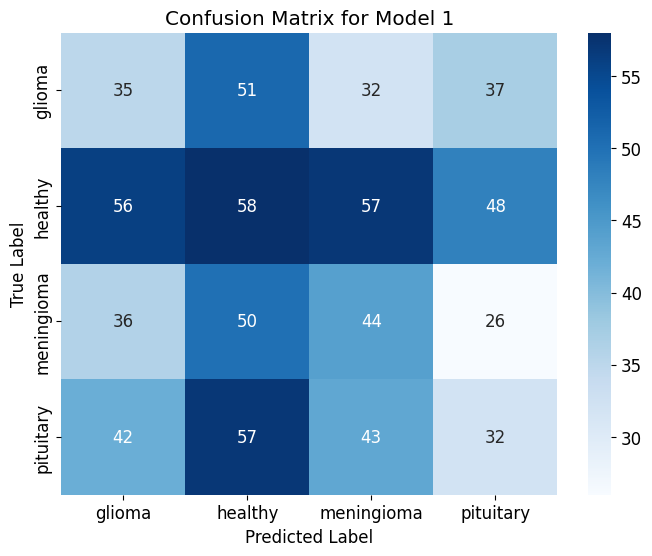

22/22 [==============================] - 7s 165ms/step
Classification Report for Model 2:

              precision    recall  f1-score   support

      glioma       0.24      0.22      0.23       154
     healthy       0.29      0.30      0.29       210
  meningioma       0.19      0.17      0.18       164
   pituitary       0.28      0.31      0.30       176

    accuracy                           0.25       704
   macro avg       0.25      0.25      0.25       704
weighted avg       0.25      0.25      0.25       704



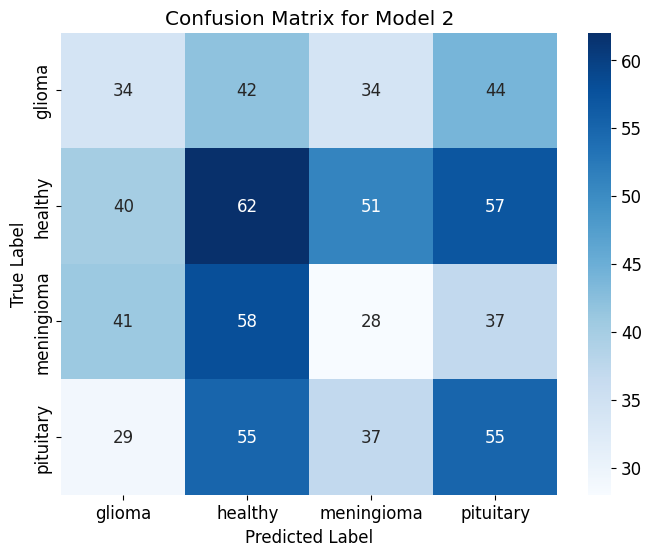

22/22 [==============================] - 4s 133ms/step
Classification Report for Model 3:

              precision    recall  f1-score   support

      glioma       0.21      0.20      0.21       153
     healthy       0.30      0.31      0.30       216
  meningioma       0.22      0.23      0.23       160
   pituitary       0.28      0.27      0.28       175

    accuracy                           0.26       704
   macro avg       0.25      0.25      0.25       704
weighted avg       0.26      0.26      0.26       704



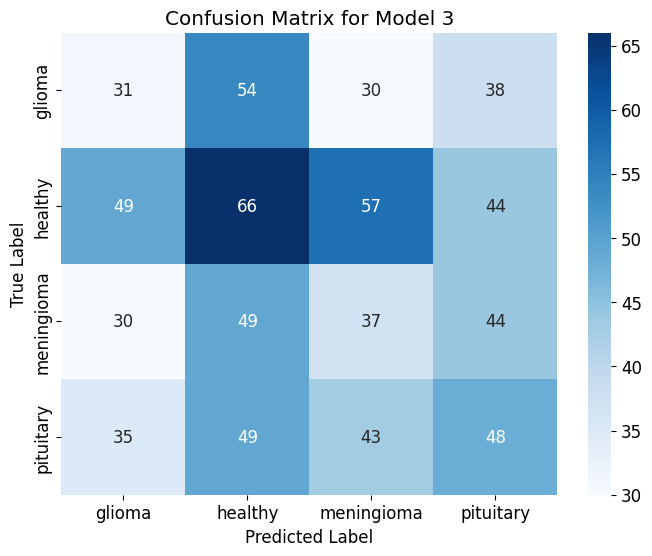

In [ ]:
for model, name in zip(models_list, model_names):
    evaluate_model(model, name)

# MODEL COMPARISON

In [ ]:
comparison_df = pd.DataFrame({
    'Model': model_names,
    'Test Accuracy': test_acc_list,
    'Test Loss': test_loss_list
})

comparison_df.sort_values('Test Accuracy', ascending=False, inplace=True)
comparison_df.reset_index(drop=True, inplace=True)
comparison_df

,Model,Test Accuracy,Test Loss
0,Model 3,0.982955,0.082819
1,Model 2,0.958807,0.211784
2,Model 1,0.680398,0.811853


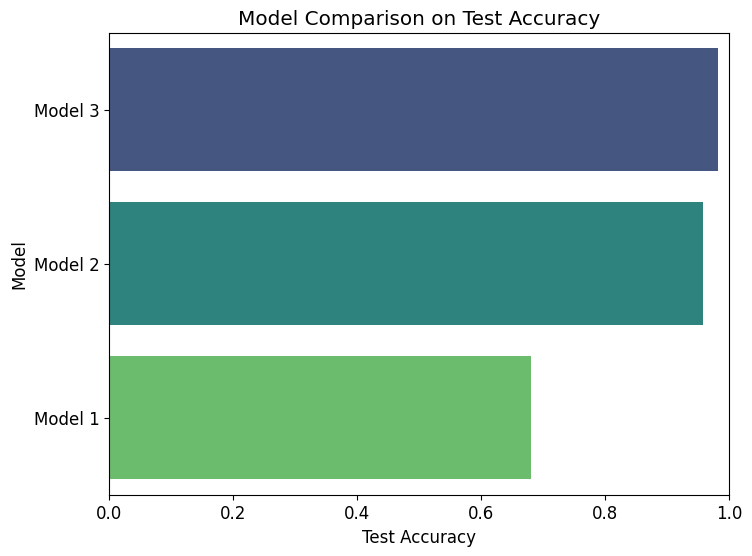

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(x='Test Accuracy', y='Model', data=comparison_df, palette='viridis')
plt.title('Model Comparison on Test Accuracy')
plt.xlabel('Test Accuracy')
plt.ylabel('Model')
plt.xlim(0, 1)
plt.show()

22/22 [==============================] - 5s 33ms/step


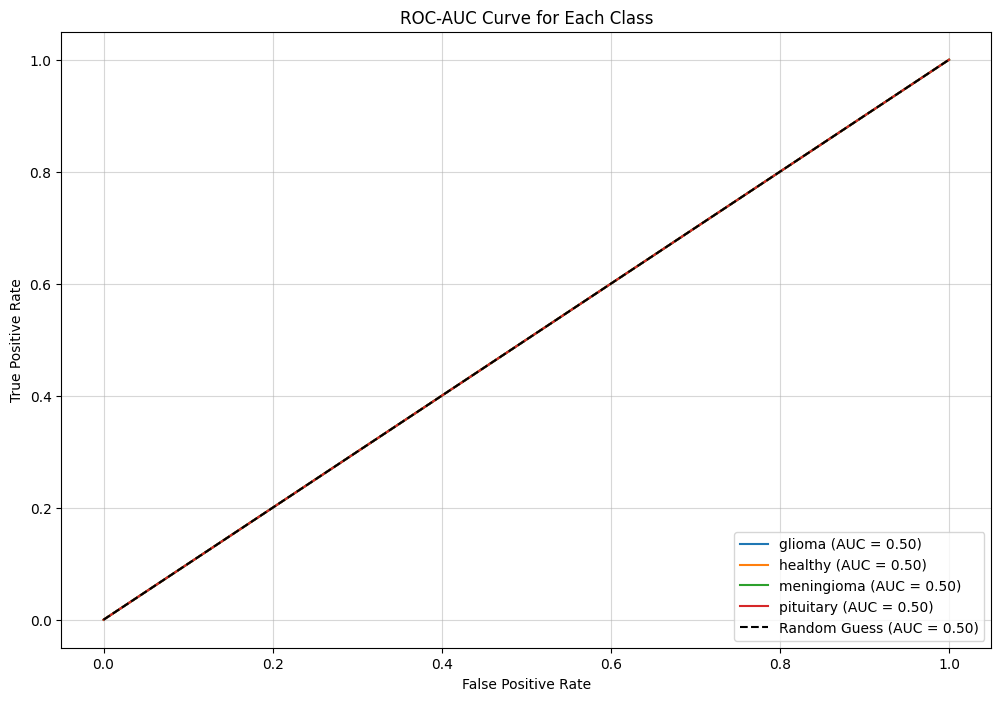

In [ ]:
# Binarize the labels for multi-class ROC calculation
y_true_binarized = label_binarize(y_true, classes=[0, 1, 2, 3])

# Get predicted probabilities for each class
y_pred_proba = savedModel_1.predict(test_ds)

n_classes = len(class_names)

# Plot ROC curve for each class
plt.figure(figsize=(12, 8))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess (AUC = 0.50)')

plt.title('ROC-AUC Curve for Each Class')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(alpha=0.5)
plt.show()

22/22 [==============================] - 10s 305ms/step


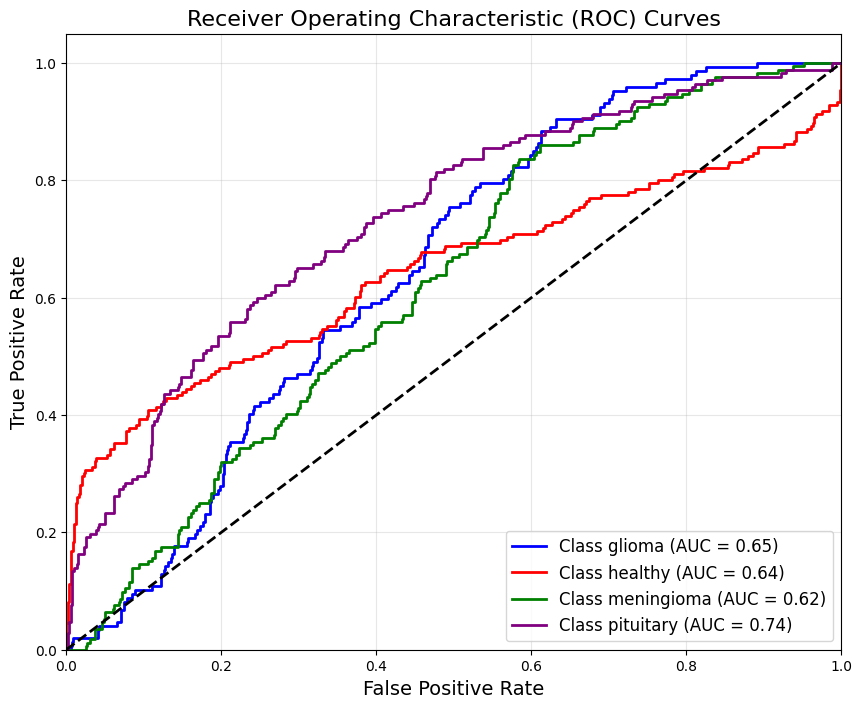

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

# Define class names
class_names = ['glioma', 'healthy', 'meningioma', 'pituitary']

# Prepare test data and labels (ensure test_ds is batched correctly)
test_images = []
test_labels = []

for images, labels in test_ds:
    test_images.append(images.numpy())
    test_labels.append(labels.numpy())

test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)

# Binarize the labels for multi-class ROC
test_labels_bin = label_binarize(test_labels, classes=range(len(class_names)))

# Predict probabilities for test dataset
y_pred = savedModel_2.predict(test_images)

# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'purple'])

for i, color in zip(range(len(class_names)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

# Plot the diagonal line for random guess
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curves', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.3)
plt.show()

22/22 [==============================] - 4s 135ms/step


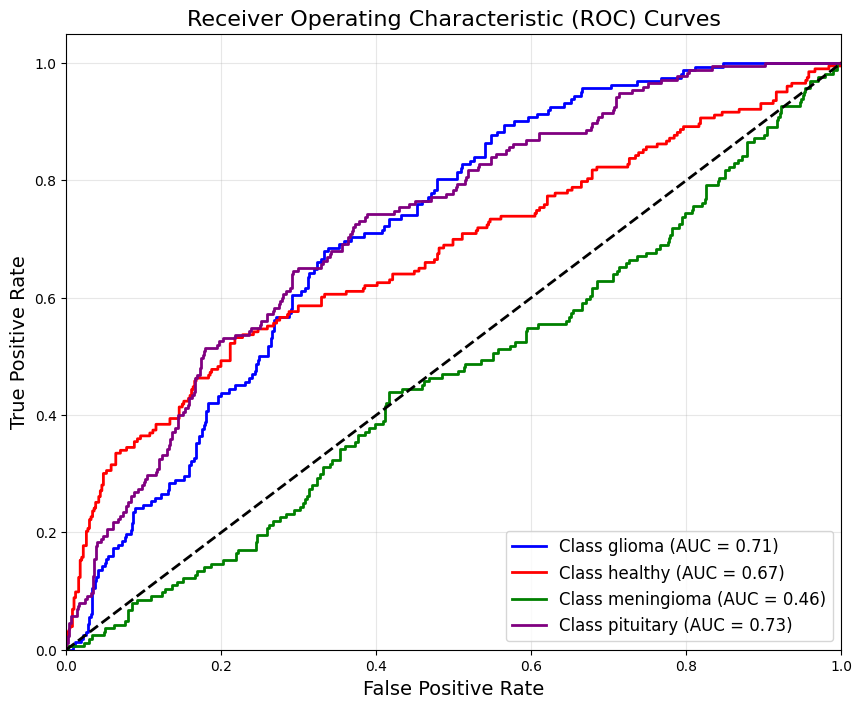

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

# Define class names
class_names = ['glioma', 'healthy', 'meningioma', 'pituitary']

# Prepare test data and labels (ensure test_ds is batched correctly)
test_images = []
test_labels = []

for images, labels in test_ds:
    test_images.append(images.numpy())
    test_labels.append(labels.numpy())

test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)

# Binarize the labels for multi-class ROC
test_labels_bin = label_binarize(test_labels, classes=range(len(class_names)))

# Predict probabilities for test dataset
y_pred = savedModel_3.predict(test_images)

# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'purple'])

for i, color in zip(range(len(class_names)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

# Plot the diagonal line for random guess
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curves', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.3)
plt.show()

# SAVING MODELS

In [ ]:
from tensorflow.keras.models import load_model
# save model
model_1.save('model1.h5')
print('Model Saved!')

Model Saved!


In [ ]:
# load model
from tensorflow.keras.models import load_model
savedModel_1=load_model('model1.h5')
#savedModel_1.summary()

In [ ]:
# save model
model_2.save('model2.h5')
print('Model Saved!')

Model Saved!


In [ ]:
# load model
from tensorflow.keras.models import load_model
savedModel_2=load_model('model2.h5')
#savedModel_2.summary()

In [ ]:
# save model
model_3.save('model3.h5')
print('Model Saved!')

Model Saved!


In [ ]:
# load model
from tensorflow.keras.models import load_model
savedModel_3=load_model('model3.h5')
#savedModel_3.summary()

# SAVING THE HISTORIES

In [ ]:
import pickle

# Extract and save only the `history` attribute
with open('model_1_history.pkl', 'wb') as f:
    pickle.dump(history_1.history, f)
print('History Saved!')

History Saved!


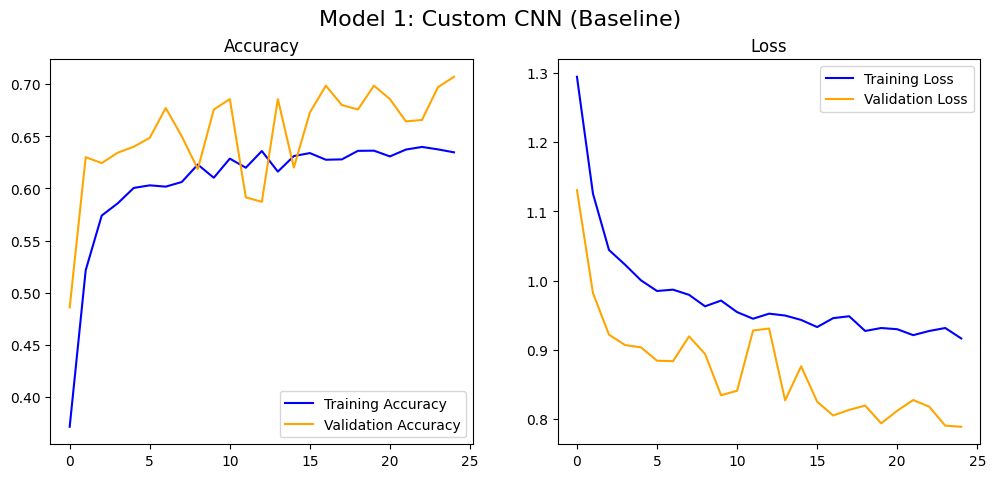

In [ ]:
# Load History
import pickle
with open('model_1_history.pkl', 'rb') as f:
    loaded_history_1 = pickle.load(f)

# Wrap the dictionary to mimic the original `History` object
class HistoryWrapper:
    def __init__(self, history):
        self.history = history

# Create a wrapped history object
loaded_history_1 = HistoryWrapper(loaded_history_1)
plot_model_history(loaded_history_1, 'Model 1: Custom CNN (Baseline)')

In [ ]:
# Extract and save only the `history` attribute
with open('model_2_history.pkl', 'wb') as f:
    pickle.dump(history_2.history, f)
print('History Saved!')

History Saved!


In [ ]:
# Load History
with open('model_2_history.pkl', 'rb') as f:
    loaded_history_2 = pickle.load(f)

# Wrap the dictionary to mimic the original `History` object
class HistoryWrapper:
    def __init__(self, history):
        self.history = history

# Create a wrapped history object
loaded_history_2 = HistoryWrapper(loaded_history_2)
#plot_model_history(loaded_history_2, 'Model 2: DenseNet201 (Fine-tuned)')

In [ ]:
# Extract and save only the `history` attribute
with open('model_3_history.pkl', 'wb') as f:
    pickle.dump(history_3.history, f)
print('History Saved!')

History Saved!


In [ ]:
# Load History
with open('model_3_history.pkl', 'rb') as f:
    loaded_history_3 = pickle.load(f)

# Wrap the dictionary to mimic the original `History` object
class HistoryWrapper:
    def __init__(self, history):
        self.history = history

# Create a wrapped history object
loaded_history_3 = HistoryWrapper(loaded_history_3)
#plot_model_history(loaded_history_3, 'Model 3: Xception (Fine-tuned)')

# MODEL 4


In [ ]:

# Image Processing
import cv2
from PIL import Image


# Visualization
import seaborn as sns
import visualkeras
from termcolor import colored

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Deep Learning
from tensorflow.keras import models, layers, Sequential
from tensorflow.keras.layers import (
    Resizing,
    Rescaling,
    Conv2D,
    MaxPooling2D,
    BatchNormalization,
    GlobalAveragePooling2D,
    Dropout,
    Dense,
)
from keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS=3
EPOCHS=40

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + val_split + test_split) == 1, "Splits must sum to 1"

    # Get the dataset size
    ds_size = ds.cardinality().numpy()
    print(f"Total dataset size: {ds_size}")

    if shuffle:
        shuffle_size = max(shuffle_size, ds_size)
        ds = ds.shuffle(shuffle_size, seed=123)

    # Calculate partition sizes
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    test_size = ds_size - train_size - val_size  # Ensure all samples are used

    # Split the dataset
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)

    return train_ds, val_ds, test_ds

# Split the dataset
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

print(f"Training batches: {len(train_ds)}")   # Output the number of training batches
print(f"Validation batches: {len(val_ds)}")  # Output the number of validation batches
print(f"Testing batches: {len(test_ds)}")    # Output the number of testing batches

Total dataset size: 220
Training batches: 176
Validation batches: 22
Testing batches: 22


In [ ]:
model4_layers = [layer.name for layer in model4.layers]
for index, layer_name in enumerate(model4_layers):
    print(f'Layer {index}: {layer_name}')

Layer 0: conv2d
Layer 1: batch_normalization
Layer 2: max_pooling2d
Layer 3: conv2d_1
Layer 4: batch_normalization_1
Layer 5: max_pooling2d_1
Layer 6: conv2d_2
Layer 7: batch_normalization_2
Layer 8: max_pooling2d_2
Layer 9: global_average_pooling2d
Layer 10: dropout
Layer 11: dense
Layer 12: dense_1


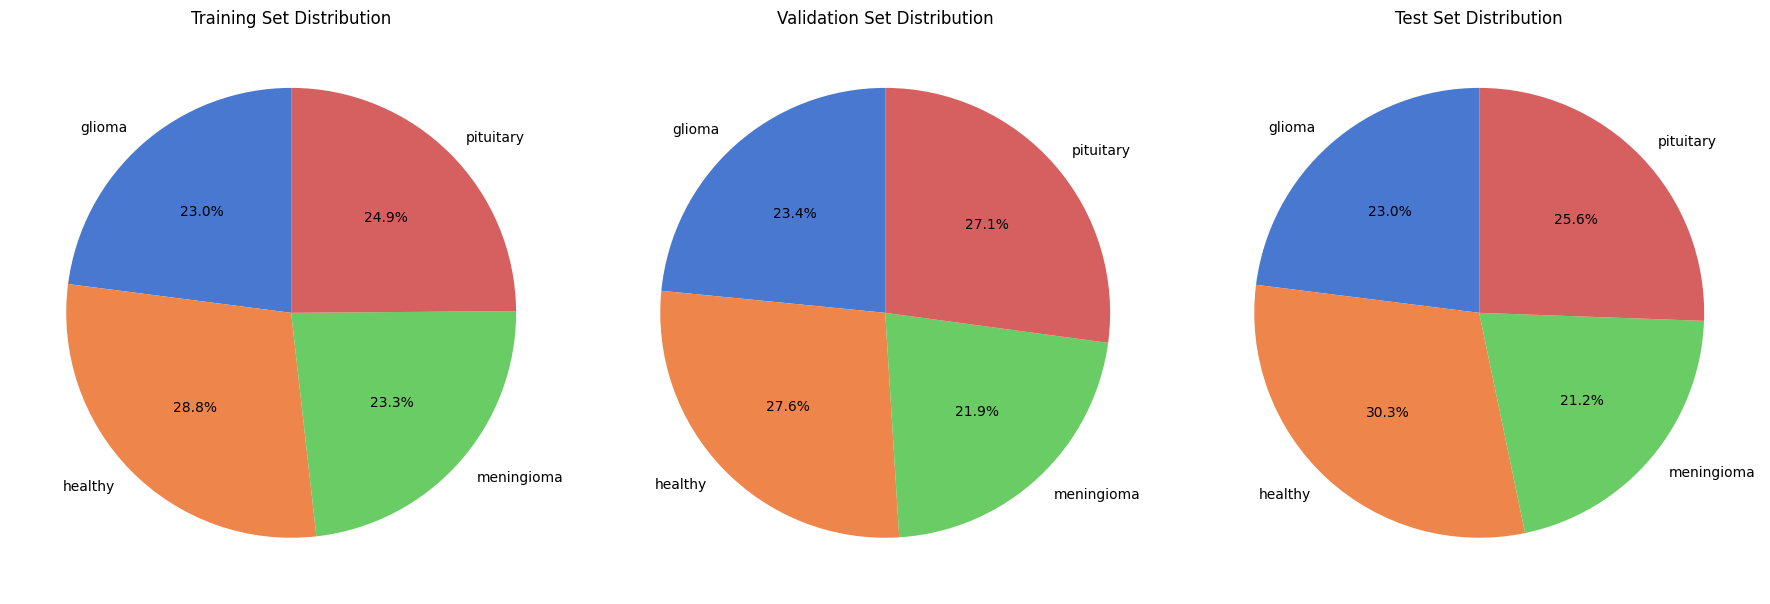

In [ ]:
class_names=dataset.class_names
class_names

def count_classes(dataset, class_names):
    class_counts = {name: 0 for name in class_names}
    for _, labels in dataset.as_numpy_iterator():
        for label in labels:
            class_counts[class_names[label]] += 1
    return class_counts

# Count class distributions
train_counts = count_classes(train_ds, class_names)
val_counts = count_classes(val_ds, class_names)
test_counts = count_classes(test_ds, class_names)

data = {
    'Training Set': train_counts,
    'Validation Set': val_counts,
    'Test Set': test_counts
}

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
muted_colors = sns.color_palette("muted", len(class_names))

for ax, (partition, counts) in zip(axes, data.items()):
    labels = counts.keys()
    sizes = counts.values()
    ax.pie(
        sizes,
        labels=labels,
        autopct='%1.1f%%',
        startangle=90,
        colors=muted_colors
    )
    ax.set_title(f'{partition} Distribution')

plt.tight_layout()
plt.show()

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  tf.keras.layers.Rescaling(1.0/255)
])

In [ ]:
# Apply preprocessing to datasets
train_ds = train_ds.map(lambda x, y: (resize_and_rescale(x), y))
val_ds = val_ds.map(lambda x, y: (resize_and_rescale(x), y))
test_ds = test_ds.map(lambda x, y: (resize_and_rescale(x), y))

In [ ]:
# Optimize performance
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

## Loading the model4 from files

In [ ]:
from tensorflow.keras.models import load_model
# load model
model4=load_model('model4.h5')
model4.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 128)     3584      
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 128)    512       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 128)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 256)     295168    
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 256)    1024      
 hNormalization)                                                 
                                                      

In [ ]:
# Generate a list of layer names
model4_layers = [layer.name for layer in model4.layers]
for index, layer_name in enumerate(model4_layers):
    print(f'Layer {index}: {layer_name}')

Layer 0: conv2d
Layer 1: batch_normalization
Layer 2: max_pooling2d
Layer 3: conv2d_1
Layer 4: batch_normalization_1
Layer 5: max_pooling2d_1
Layer 6: conv2d_2
Layer 7: batch_normalization_2
Layer 8: max_pooling2d_2
Layer 9: global_average_pooling2d
Layer 10: dropout
Layer 11: dense
Layer 12: dense_1


In [ ]:
# Compile Model
model4.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

## Loading training history from files

In [ ]:
import pickle

# Load History
with open('model_4_history.pkl', 'rb') as f:
    history4 = pickle.load(f)

# Wrap the dictionary to mimic the original `History` object
class HistoryWrapper:
    def __init__(self, history):
        self.history = history

# Create a wrapped history object
history4 = HistoryWrapper(history4)

In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True,
                               verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=3,
                              verbose=1,
                              min_lr=1e-6)

callbacks = [early_stopping, reduce_lr]

In [ ]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model4.evaluate(test_ds, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

22/22 [==============================] - 6s 83ms/step - loss: 0.0439 - accuracy: 0.9886
Test Loss: 0.0439
Test Accuracy: 98.86%


In [ ]:
# Evaluate the model on the validation dataset
val_loss, val_accuracy = model4.evaluate(val_ds, verbose=1)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

22/22 [==============================] - 6s 88ms/step - loss: 0.0524 - accuracy: 0.9858
Validation Loss: 0.0524
Validation Accuracy: 98.58%


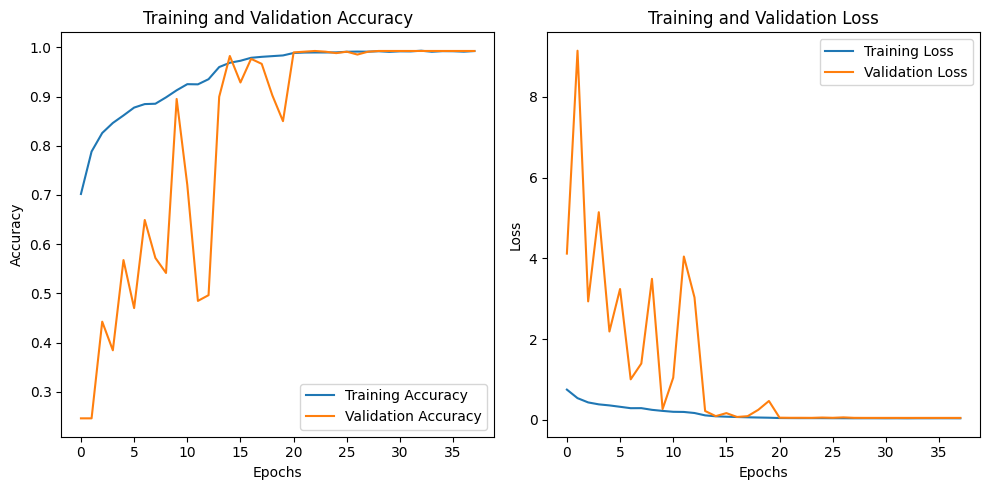

In [ ]:
# Training and Validation Curves
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history4.history['accuracy'], label='Training Accuracy')
plt.plot(history4.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history4.history['loss'], label='Training Loss')
plt.plot(history4.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# CONFUSION MATRIX

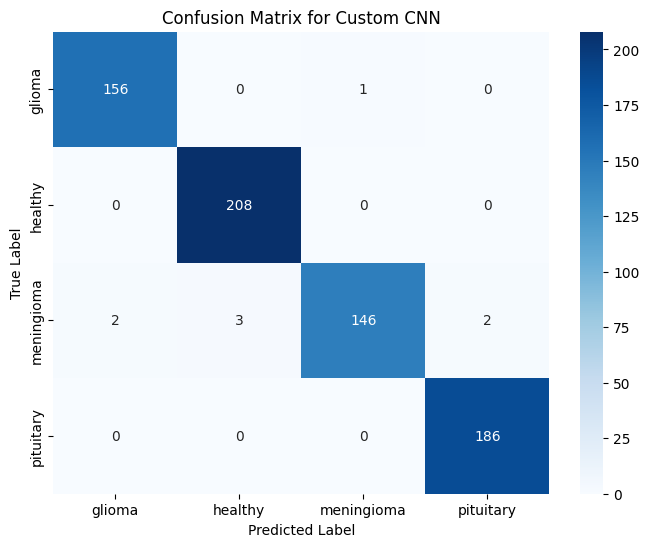

              precision    recall  f1-score   support

      glioma       0.99      0.99      0.99       157
     healthy       0.99      1.00      0.99       208
  meningioma       0.99      0.95      0.97       153
   pituitary       0.99      1.00      0.99       186

    accuracy                           0.99       704
   macro avg       0.99      0.99      0.99       704
weighted avg       0.99      0.99      0.99       704



In [ ]:
# Collect all predictions in one step
y_true = []
y_pred = []

# Loop through test dataset and collect true labels and predictions
for images, labels in test_ds:
    y_true.extend(labels.numpy())
    preds = model4(images, training=False)  # Disable verbose outputs by turning off training mode
    y_pred.extend(tf.argmax(preds, axis=1).numpy())

# Generate Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'Confusion Matrix for Custom CNN')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=class_names))

# MAKING PREDICTIONS

In [ ]:
# Map predicted labels back to class names
y_pred_class_names = [class_names[pred] for pred in y_pred]
y_true_class_names = [class_names[true] for true in y_true]

# Display correct and incorrect predictions with colors
print("Sample Predictions:")
num_samples = 10
for i in range(num_samples):
    # Check if the prediction is correct
    if y_pred_class_names[i] == y_true_class_names[i]:
        pred_text = colored(y_pred_class_names[i], 'green')
    else:
        pred_text = colored(y_pred_class_names[i], 'red')

    print(f"Sample {i + 1}:")
    print(f"  True Label: {y_true_class_names[i]}")
    print(f"  Predicted Label: {pred_text}")
    print("-" * 30)

# Identify and display misclassified samples
print("\nMisclassified Samples:")
misclassified_samples = [
    (i, true, pred) for i, (true, pred) in enumerate(zip(y_true_class_names, y_pred_class_names)) if true != pred
]

if misclassified_samples:
    print(f"Total Misclassifications: {len(misclassified_samples)}\n")
    for sample in misclassified_samples[:5]:
        index, true_label, pred_label = sample
        print(f"Sample Index: {index}")
        print(f"  True Label: {true_label}")
        print(f"  Predicted Label: {colored(pred_label, 'red')}")
        print("-" * 30)
else:
    print("No misclassifications detected!")

Sample Predictions:
Sample 1:
  True Label: meningioma
  Predicted Label: meningioma
------------------------------
Sample 2:
  True Label: glioma
  Predicted Label: glioma
------------------------------
Sample 3:
  True Label: glioma
  Predicted Label: glioma
------------------------------
Sample 4:
  True Label: healthy
  Predicted Label: healthy
------------------------------
Sample 5:
  True Label: pituitary
  Predicted Label: pituitary
------------------------------
Sample 6:
  True Label: pituitary
  Predicted Label: pituitary
------------------------------
Sample 7:
  True Label: glioma
  Predicted Label: glioma
------------------------------
Sample 8:
  True Label: pituitary
  Predicted Label: pituitary
------------------------------
Sample 9:
  True Label: healthy
  Predicted Label: healthy
------------------------------
Sample 10:
  True Label: healthy
  Predicted Label: healthy
------------------------------

Misclassified Samples:
Total Misclassifications: 8

Sample Index: 

# ROC-AUC CURVE

22/22 [==============================] - 7s 91ms/step


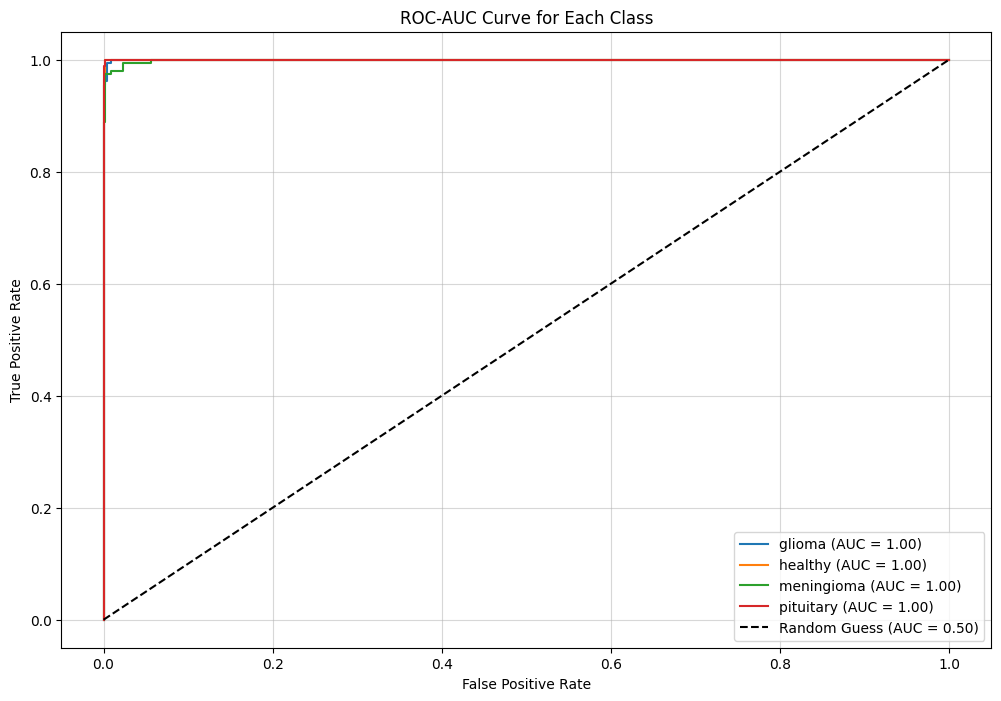

In [ ]:
# Binarize the labels for multi-class ROC calculation
y_true_binarized = label_binarize(y_true, classes=[0, 1, 2, 3])

# Get predicted probabilities for each class
y_pred_proba = model4.predict(test_ds)

n_classes = len(class_names)

# Plot ROC curve for each class
plt.figure(figsize=(12, 8))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess (AUC = 0.50)')

plt.title('ROC-AUC Curve for Each Class')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(alpha=0.5)
plt.show()